```
@inproceedings{
    fu2024a,
    title={A Touch, Vision, and Language Dataset for Multimodal Alignment},
    author={Letian Fu and Gaurav Datta and Huang Huang and William Chung-Ho Panitch and Jaimyn Drake and Joseph Ortiz and Mustafa Mukadam and Mike Lambeta and Roberto Calandra and Ken Goldberg},
    booktitle={Forty-first International Conference on Machine Learning},
    year={2024},
    url={https://openreview.net/forum?id=tFEOOH9eH0}
}
```

In [1]:
from tvl_enc.tvl import TVL, ModalityType
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Set device to GPU if available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

List the models in timm that is vit.

In [2]:
import timm
import re

model_names = timm.list_models()
for name in model_names:
    if re.match(r'^vit.*224$', name):
        print(name)


vit_base_patch8_224
vit_base_patch16_18x2_224
vit_base_patch16_224
vit_base_patch16_clip_224
vit_base_patch16_gap_224
vit_base_patch16_rpn_224
vit_base_patch16_xp_224
vit_base_patch32_224
vit_base_patch32_clip_224
vit_base_r26_s32_224
vit_base_r50_s16_224
vit_base_resnet26d_224
vit_base_resnet50d_224
vit_giant_patch14_224
vit_giant_patch14_clip_224
vit_gigantic_patch14_224
vit_gigantic_patch14_clip_224
vit_huge_patch14_224
vit_huge_patch14_clip_224
vit_huge_patch14_xp_224
vit_large_patch14_224
vit_large_patch14_clip_224
vit_large_patch14_xp_224
vit_large_patch16_224
vit_large_patch32_224
vit_large_r50_s32_224
vit_relpos_base_patch16_224
vit_relpos_base_patch16_cls_224
vit_relpos_base_patch16_clsgap_224
vit_relpos_base_patch16_rpn_224
vit_relpos_medium_patch16_224
vit_relpos_medium_patch16_cls_224
vit_relpos_medium_patch16_rpn_224
vit_relpos_small_patch16_224
vit_relpos_small_patch16_rpn_224
vit_small_patch8_224
vit_small_patch16_18x2_224
vit_small_patch16_36x1_224
vit_small_patch16_224

### To plot the result

In [3]:
def plot_prob(image_path, texts, probs, title):
    # Visualize the image and similarity scores with a horizontal bar chart
    plt.figure(figsize=(15, 5))
    ax_img = plt.subplot(1, 2, 1)

    # Display the image on the left
    img = Image.open(image_path)
    ax_img.imshow(img)
    ax_img.axis('off')  # Hide axis for image
    ax_img.set_title(title)

    # Create a new figure for the bar chart (on the right)
    ax_img = plt.subplot(1, 2, 2)

    # Plot similarity probabilities for each text label
    y_pos = np.arange(len(texts))
    ax_img.barh(y_pos, probs, color='skyblue')
    ax_img.set_yticks(y_pos)
    ax_img.set_yticklabels(texts)
    ax_img.invert_yaxis()  # Highest probability on top
    ax_img.set_xlabel('Similarity Probability')
    ax_img.set_title(title)

    # Display both plots
    plt.tight_layout()
    plt.show()

### Load the encoder model and CLIP model in TVL_enc.tvl
* Use CLIP model for vision and text.
    ```
    CLIP_VISION_MODEL = "ViT-L-14"
    CLIP_PRETRAIN_DATA = "datacomp_xl_s13b_b90k"
    ```
*  `tactile_model="vit_tiny_patch16_224"`
* Do inference.

In [4]:
MODEL_IDX = 1 # select below model
model_list = {
    "vit_tiny_patch16_224":r"D:\NSYSU_Fourth_grade\ADV_ML_Final_Project\checkpoints\tvl_enc_vittiny.pth",
    "vit_small_patch32_224":r"D:\NSYSU_Fourth_grade\ADV_ML_Final_Project\checkpoints\tvl_enc_vits.pth",
    "vit_base_patch16_224":r"D:\NSYSU_Fourth_grade\ADV_ML_Final_Project\checkpoints\tvl_enc_vitb.pth", # 2nd good
}
# Create TVL model instance with active modalities
model_tvl = TVL(
    active_modalities=[ModalityType.VISION, ModalityType.TACTILE, ModalityType.TEXT],
    tactile_model=list(model_list.keys())[MODEL_IDX]
).to(device)
model_tvl.eval()

# Load tactile encoder checkpoint
ckpt_path = list(model_list.values())[MODEL_IDX]
state_dict = torch.load(ckpt_path, map_location=device, weights_only=False)
model_tvl.load_state_dict(state_dict, strict=False)

# Load vision preprocessing transform (from OpenCLIP)
vision_preprocess = model_tvl.vision_preprocess

### Selected from train.csv, and choose 5 sets descriptions to test.
| 英文           | 中文    | 說明            |
| :----------- | :---- | :------------ |
| **smooth**   | 平滑    | 表面平順，無顆粒或凹凸感  |
| **rough**    | 粗糙    | 表面不平整，摸起來有阻力感 |
| **soft**     | 柔軟    | 可被壓縮、容易變形     |
| **hard**     | 堅硬    | 無法輕易變形，觸感堅實   |
| **warm**     | 溫暖    | 觸感偏熱，溫度高      |
| **cool**     | 冰涼    | 觸感偏冷，溫度低      |
| **flexible** | 有彈性   | 可彎曲、不易折斷      |
| **rigid**    | 僵硬    | 無法彎曲，容易斷裂     |
| **glossy**   | 光滑有光澤 | 表面反光、亮面       |
| **matte**    | 霧面無光  | 表面無反光、偏暗淡     |


In [5]:
# # Define text labels, use all texts as text input for inference, to see which cosine similarity is the max.
# tactile_opposites = [
#     "smooth", "rough",       # 平滑 ↔ 粗糙
#     "soft", "hard",          # 柔軟 ↔ 堅硬
#     "warm", "cool",          # 溫暖 ↔ 冰涼
#     "flexible", "rigid",     # 有彈性 ↔ 僵硬
#     "glossy", "matte"        # 光滑有光澤 ↔ 霧面無光
# ]


In [6]:
# import pandas as pd
# import random
# import re
# random.seed(42)
# # Load CSV data
# df = pd.read_csv(r"D:\NSYSU_Fourth_grade\ADV_ML_Final_Project\tvl\my_implementation\subset_dataset\hct\data1\train.csv")

# # Collect all captions from the 'caption' column
# captions = df['caption'].tolist()

# # Extract all single-word tactile descriptions from captions
# all_words = []
# for caption in captions:
#     words = re.findall(r'\b[a-z]+\b', caption.lower())
#     all_words.extend(words)

# # Remove duplicates
# unique_words = list(set(all_words))

# # Define tactile categories with example adjectives
# categories = {
#     'rough': ['rough', 'bumpy', 'grainy', 'gritty', 'textured', 'dimpled'],
#     'soft': ['soft', 'yielding', 'rubbery', 'knitted', 'cloth'],
#     'smooth': ['smooth', 'slick', 'polished'],
#     'hard': ['hard', 'rigid', 'solid', 'dense', 'durable']
# }

# # Initialize classification result dictionary
# classified_words = {k: [] for k in categories}
# unclassified_words = []

# # Classify each unique word into predefined categories
# for word in unique_words:
#     found = False
#     for k, v in categories.items():
#         if word in v:
#             classified_words[k].append(word)
#             found = True
#             break
#     if not found:
#         unclassified_words.append(word)

# # Print out the classified words for each category
# for cat, words in classified_words.items():
#     print(f"{cat}: {words}")

# # Print out words that were not classified
# print(f"Unclassified: {unclassified_words}")

# # Randomly create multiple groups:
# # each group has 5 words: 3 from a randomly selected category + 2 from other categories
# groups = []
# for _ in range(5):
#     group = []
#     # Randomly pick a main category
#     main_cat = random.choice(list(categories.keys()))
#     # Randomly sample up to 3 words from the main category
#     similar_words = random.sample(classified_words[main_cat], min(3, len(classified_words[main_cat])))
#     # Randomly pick 2 words from other categories
#     other_cats = [c for c in categories.keys() if c != main_cat]
#     other_words = []
#     for oc in random.sample(other_cats, 2):
#         if classified_words[oc]:
#             other_words.append(random.choice(classified_words[oc]))
#     # Combine words into one group
#     group.extend(similar_words)
#     group.extend(other_words)
#     groups.append(group)

# # Display each group result
# for i, g in enumerate(groups):
#     print(f"Group {i+1}: {g}")


In [7]:
# groups

In [8]:
tactile_opposites = ["soft texture", "hard surface", "rough", "smooth"]

In [9]:
def inference_on_image(tactile_image_path, image_path, texts, model_tvl):
    # Load and preprocess tactile and vision images
    tactile_image = vision_preprocess(Image.open(tactile_image_path)).unsqueeze(0).to(device)
    vision_image  = vision_preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    # Tokenize text descriptions
    text_tokens = model_tvl.tokenizer(texts).to(device)

    # Prepare input dictionary for the model
    input_dict = {
        ModalityType.TACTILE: tactile_image,
        ModalityType.VISION: vision_image,
        ModalityType.TEXT: text_tokens
    }

    # Perform forward pass without gradient computation
    with torch.no_grad():
        output = model_tvl(input_dict)

    # Extract modality features and logit scale from the output
    tactile_feature = output[ModalityType.TACTILE]   # (1, dim)
    vision_features = output[ModalityType.VISION]    # (1, dim)
    text_features   = output[ModalityType.TEXT]      # (4, dim)
    logit_scale     = output["logit_scale"]          # scalar

    # Compute similarity logits between vision features and text features
    logit_scale = logit_scale.to(vision_features.device)
    logits_per_image = logit_scale * vision_features @ text_features.t()  # (1, 4)
    logits_per_text  = logits_per_image.t()                               # (4, 1)

    # Convert logits to probabilities using softmax
    probs = logits_per_image.softmax(dim=-1).cpu().numpy().flatten()

    plot_prob(image_path, texts, probs, "Vision-to-Text Similarity")

    # Compute similarity logits between tactile features and text features
    logit_scale = logit_scale.to(tactile_feature.device)
    logits_per_image = logit_scale * tactile_feature @ text_features.t()  # (1, 4)
    logits_per_text  = logits_per_image.t()                               # (4, 1)

    # Convert logits to probabilities using softmax
    probs = logits_per_image.softmax(dim=-1).cpu().numpy().flatten()

    plot_prob(tactile_image_path, texts, probs, "Tactile-to-Text Similarity")

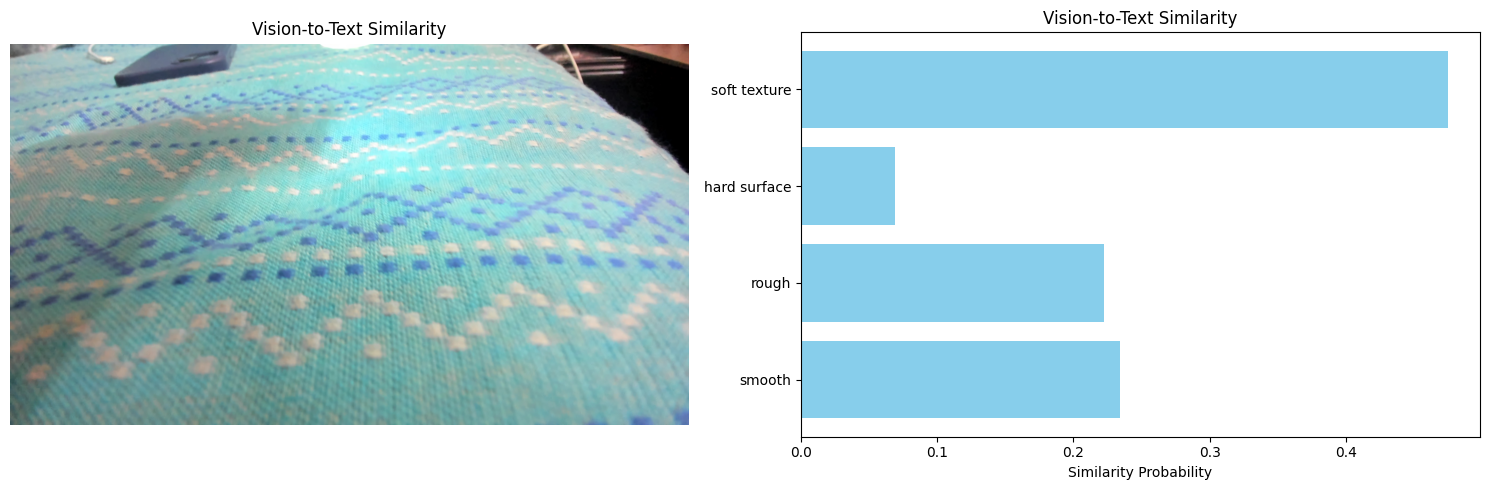

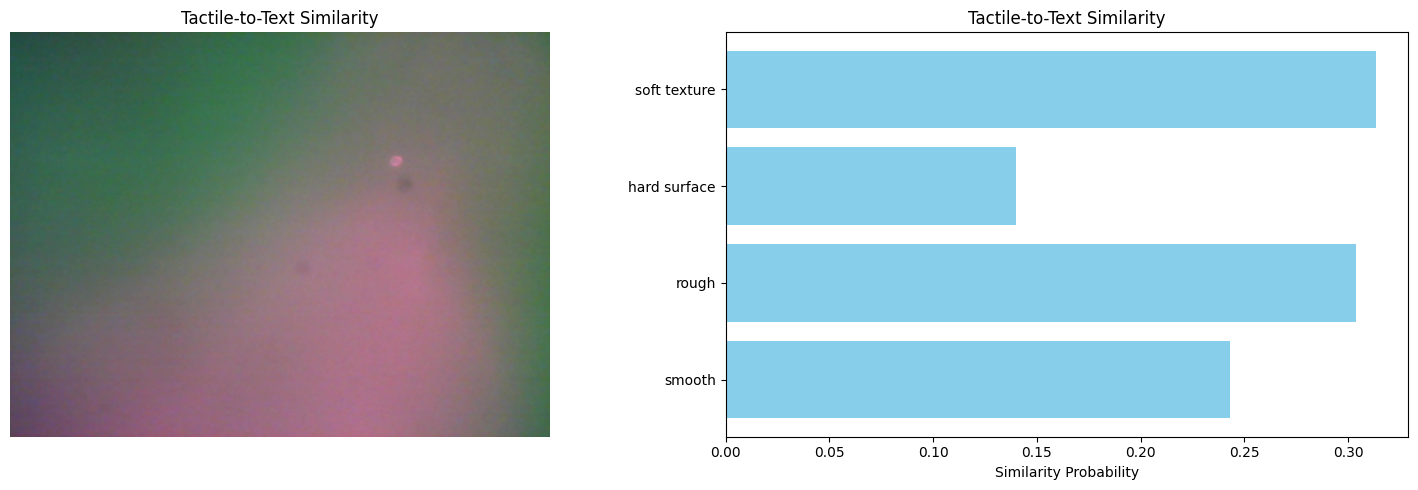

In [10]:
IMAGE_NAME = '93-0.0398557186126709'
TACTILE_IMAGE_PATH = "tactile/"+IMAGE_NAME+".jpg"
IMAGE_PATH = "image/"+IMAGE_NAME+".jpg"

# Do inference
inference_on_image(TACTILE_IMAGE_PATH, IMAGE_PATH, tactile_opposites, model_tvl)

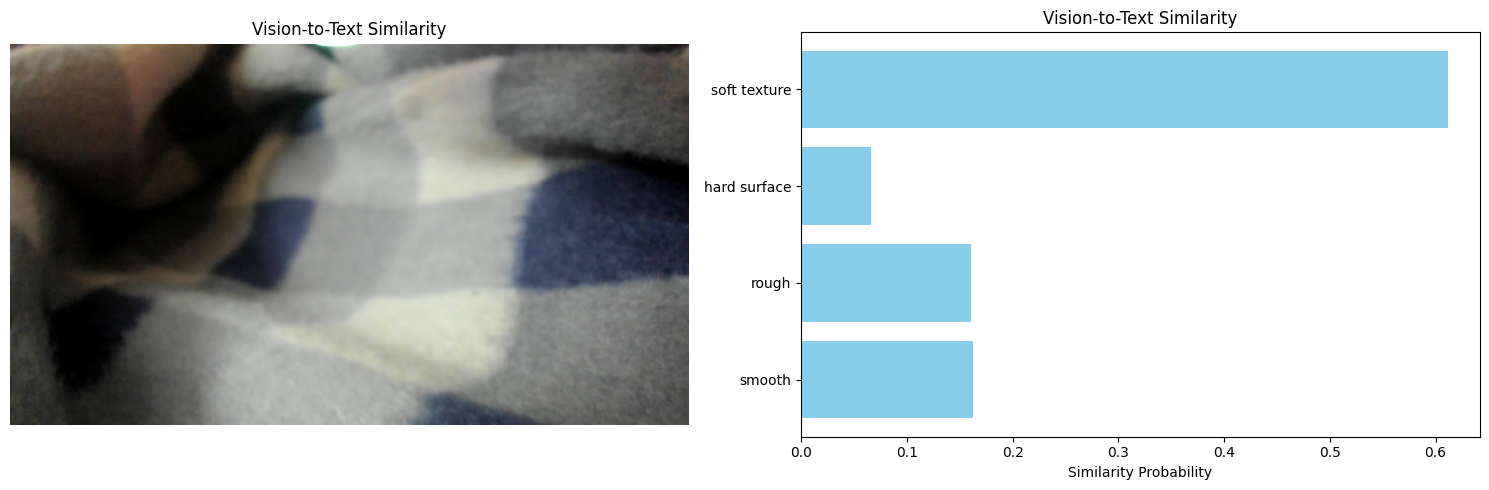

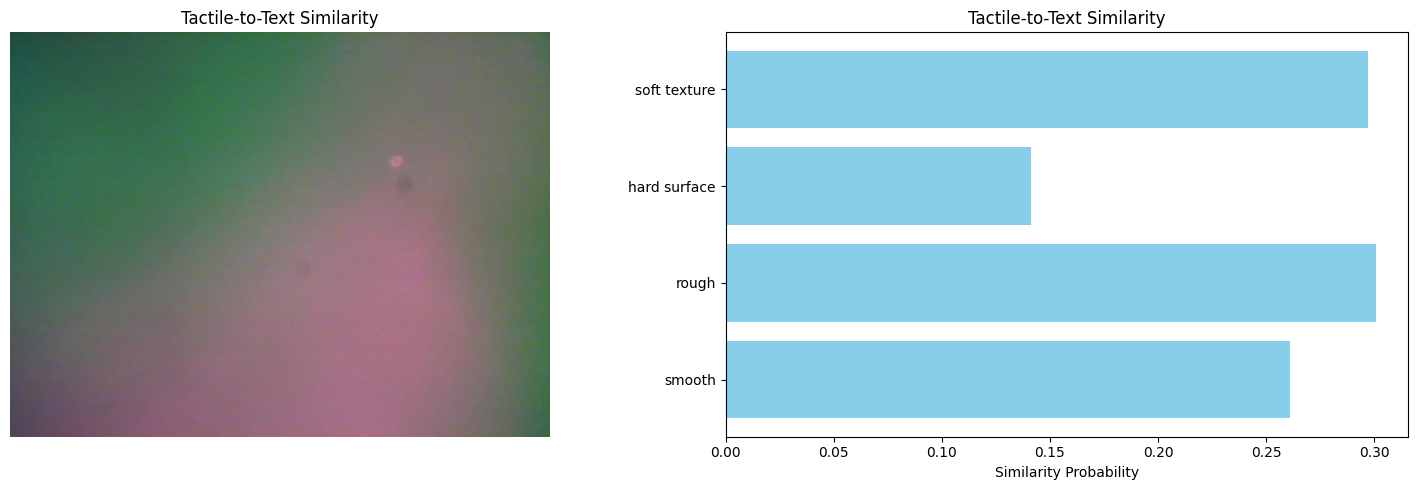

In [12]:
IMAGE_NAME = '65-0.03529810905456543'
TACTILE_IMAGE_PATH = "tactile/"+IMAGE_NAME+".jpg"
IMAGE_PATH = "image/"+IMAGE_NAME+".jpg"

# Do inference
inference_on_image(TACTILE_IMAGE_PATH, IMAGE_PATH, tactile_opposites, model_tvl)

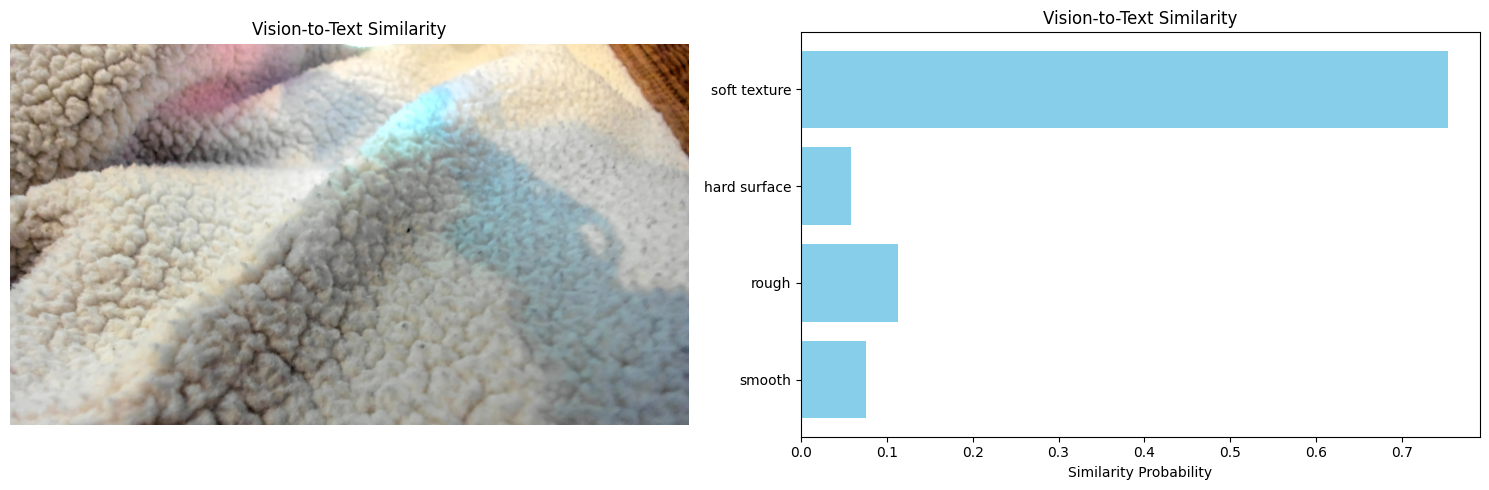

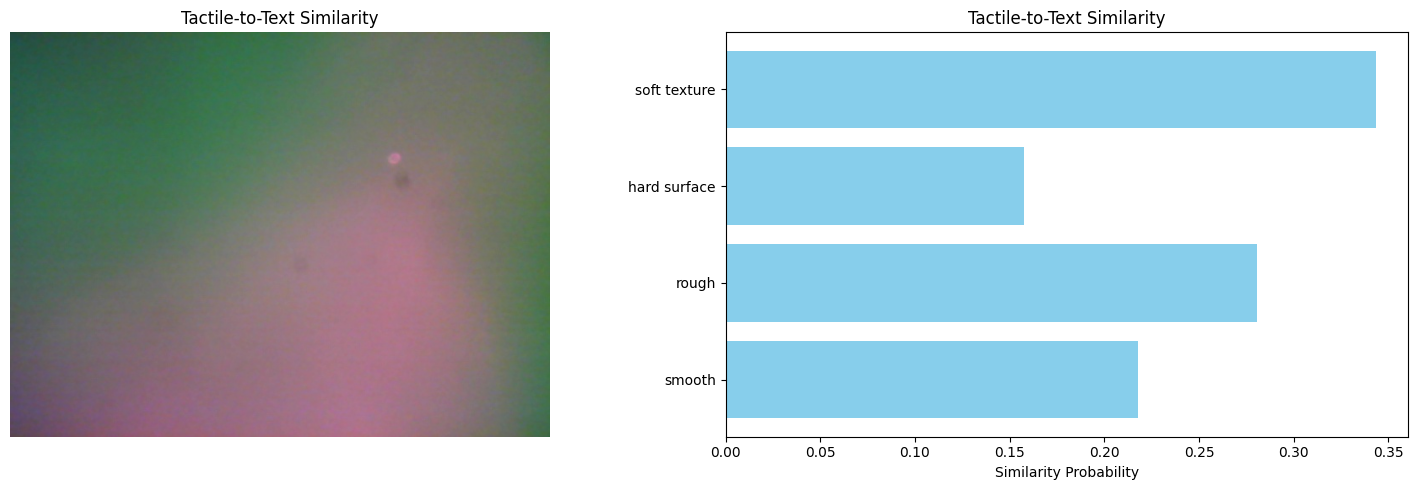

In [13]:
IMAGE_NAME = '32-0.02621626853942871'
TACTILE_IMAGE_PATH = "tactile/"+IMAGE_NAME+".jpg"
IMAGE_PATH = "image/"+IMAGE_NAME+".jpg"

# Do inference
inference_on_image(TACTILE_IMAGE_PATH, IMAGE_PATH, tactile_opposites, model_tvl)

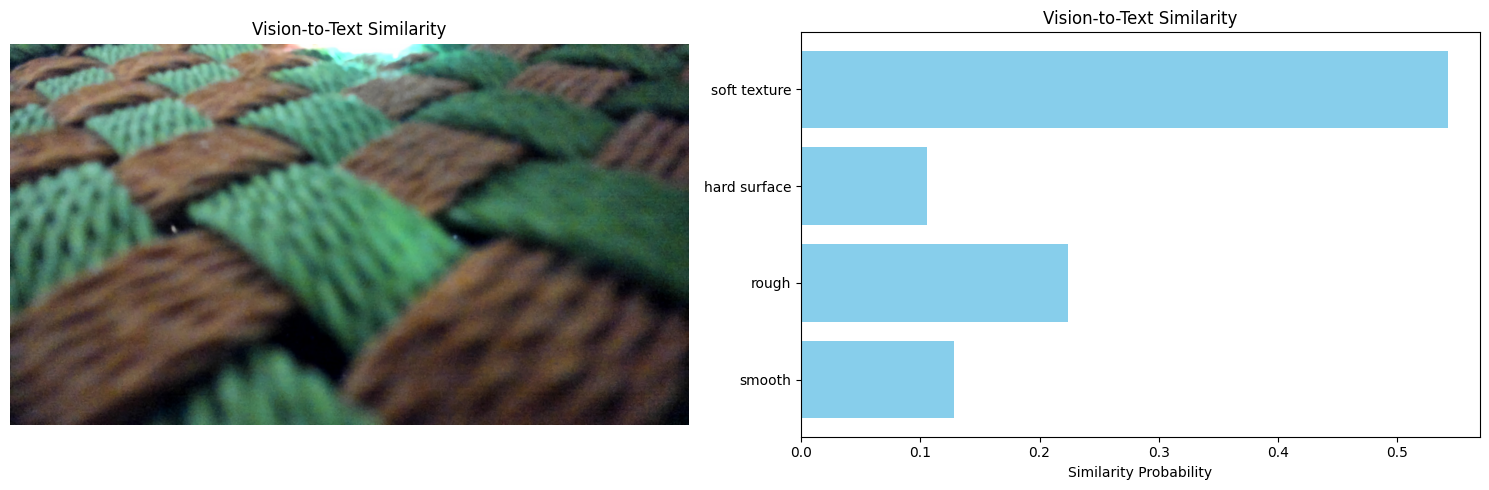

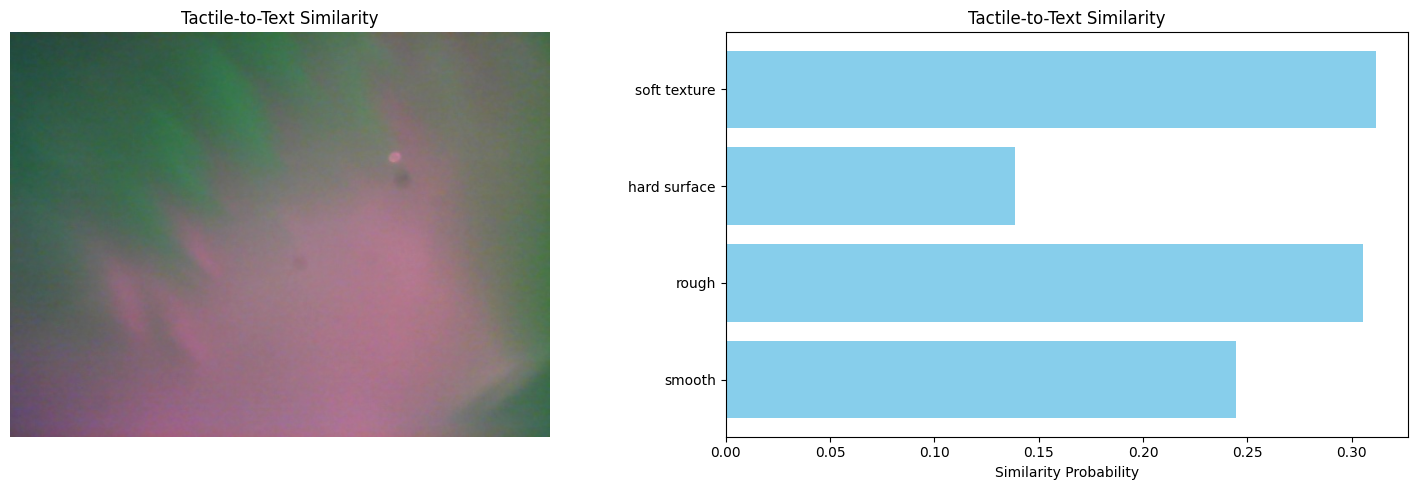

In [14]:
IMAGE_NAME = '132-0.03245687484741211'
TACTILE_IMAGE_PATH = "tactile/"+IMAGE_NAME+".jpg"
IMAGE_PATH = "image/"+IMAGE_NAME+".jpg"

# Do inference
inference_on_image(TACTILE_IMAGE_PATH, IMAGE_PATH, tactile_opposites, model_tvl)

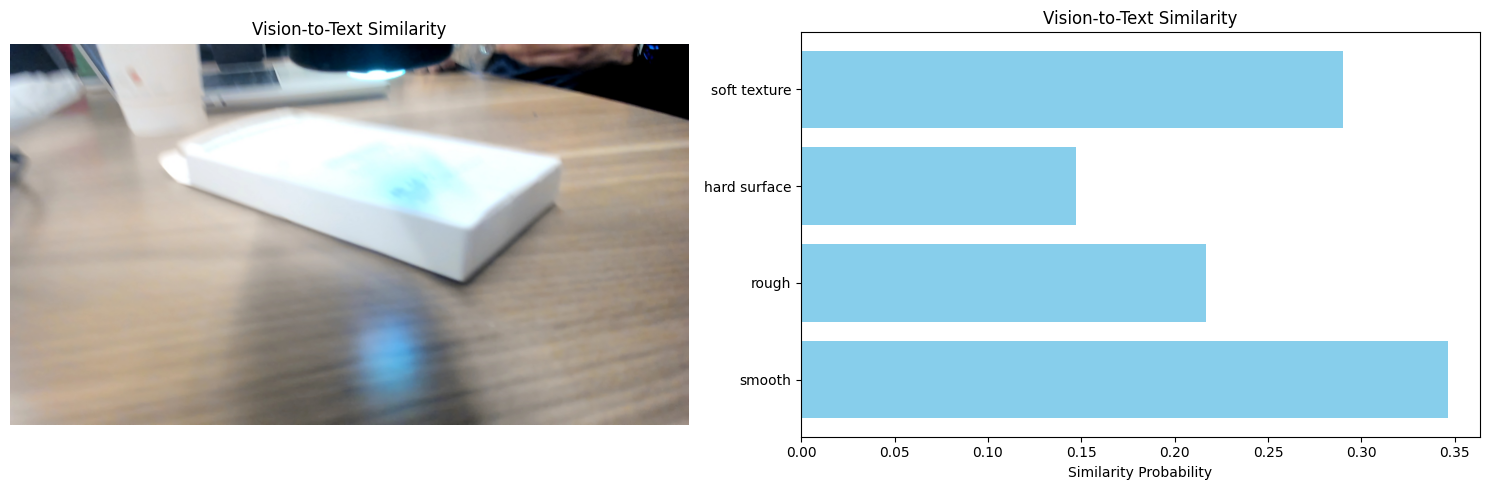

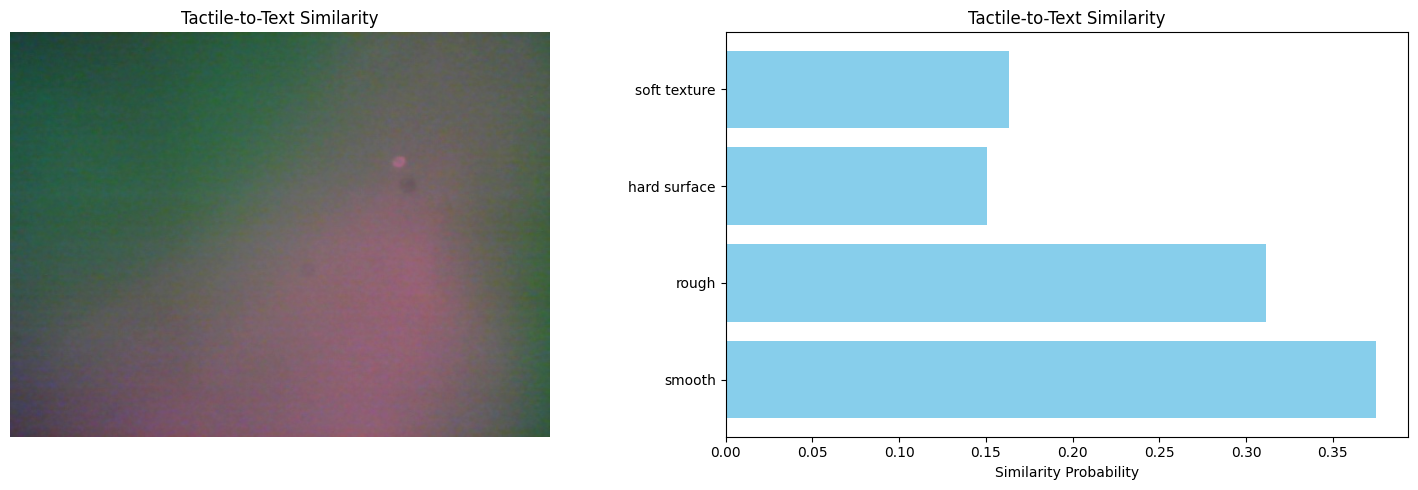

In [15]:
IMAGE_NAME = '158-0.033889055252075195'
TACTILE_IMAGE_PATH = "tactile/"+IMAGE_NAME+".jpg"
IMAGE_PATH = "image/"+IMAGE_NAME+".jpg"

# Do inference
inference_on_image(TACTILE_IMAGE_PATH, IMAGE_PATH, tactile_opposites, model_tvl)

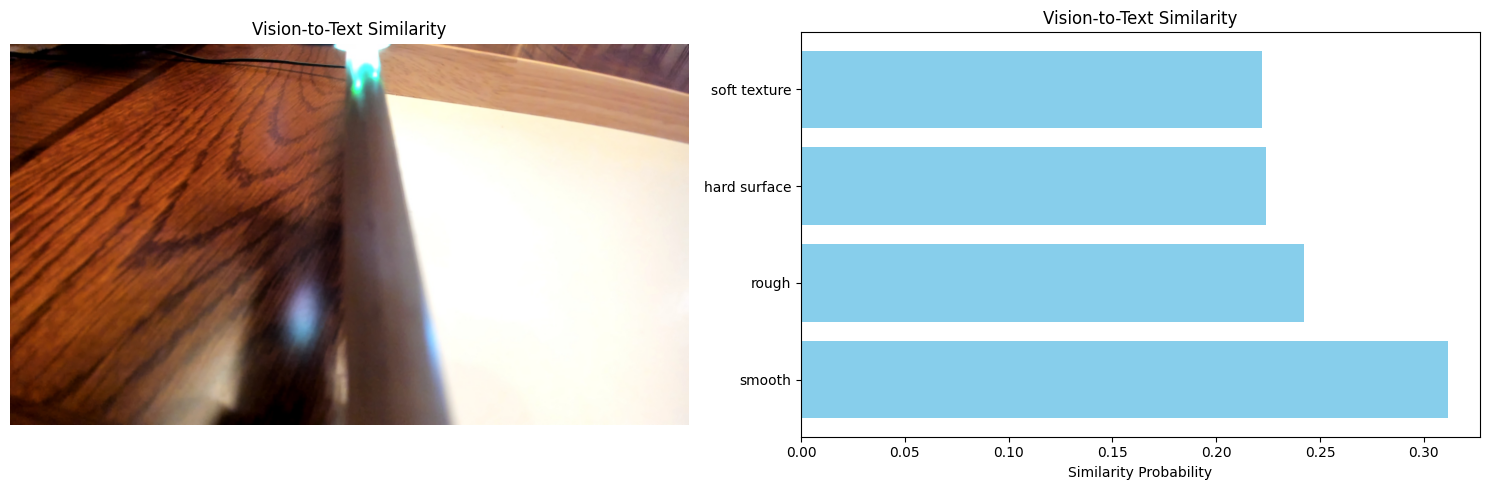

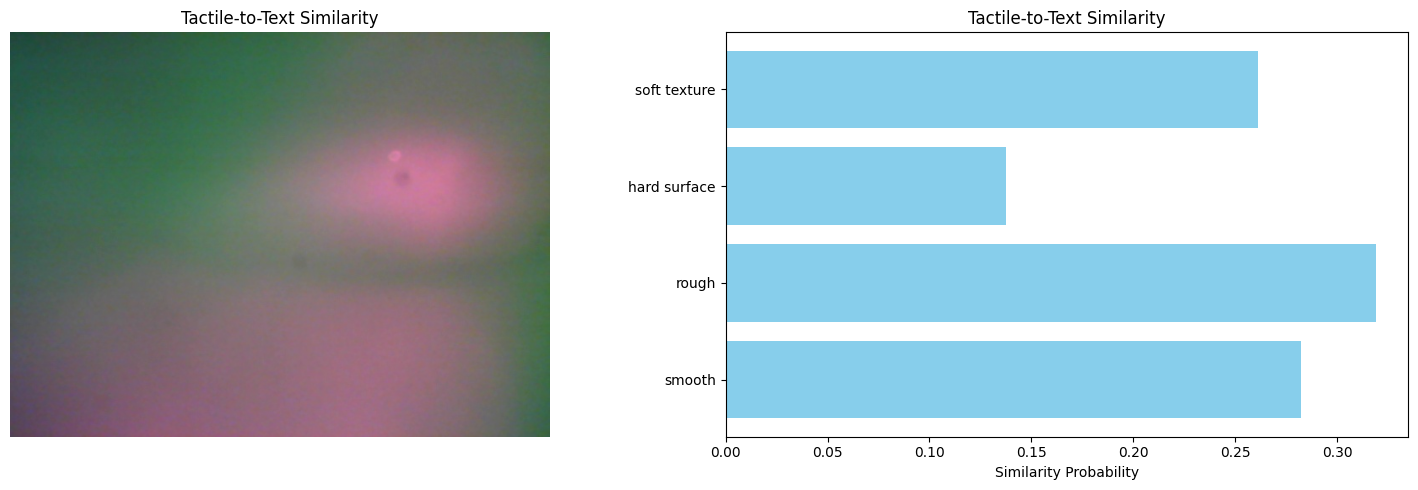

In [16]:
IMAGE_NAME = '158-0.03528618812561035'
TACTILE_IMAGE_PATH = "tactile/"+IMAGE_NAME+".jpg"
IMAGE_PATH = "image/"+IMAGE_NAME+".jpg"

# Do inference
inference_on_image(TACTILE_IMAGE_PATH, IMAGE_PATH, tactile_opposites, model_tvl)

In [17]:
model_tvl

TVL(
  (clip): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-23): 24 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
            )
            (ls_2): Identity()
          )
        )
   

In [18]:
tactile_opposites = ["hard", "flexible", "grainy", "cloth-like"] #“硬”、“柔韌”、“顆粒感”、“光滑”、“布狀”

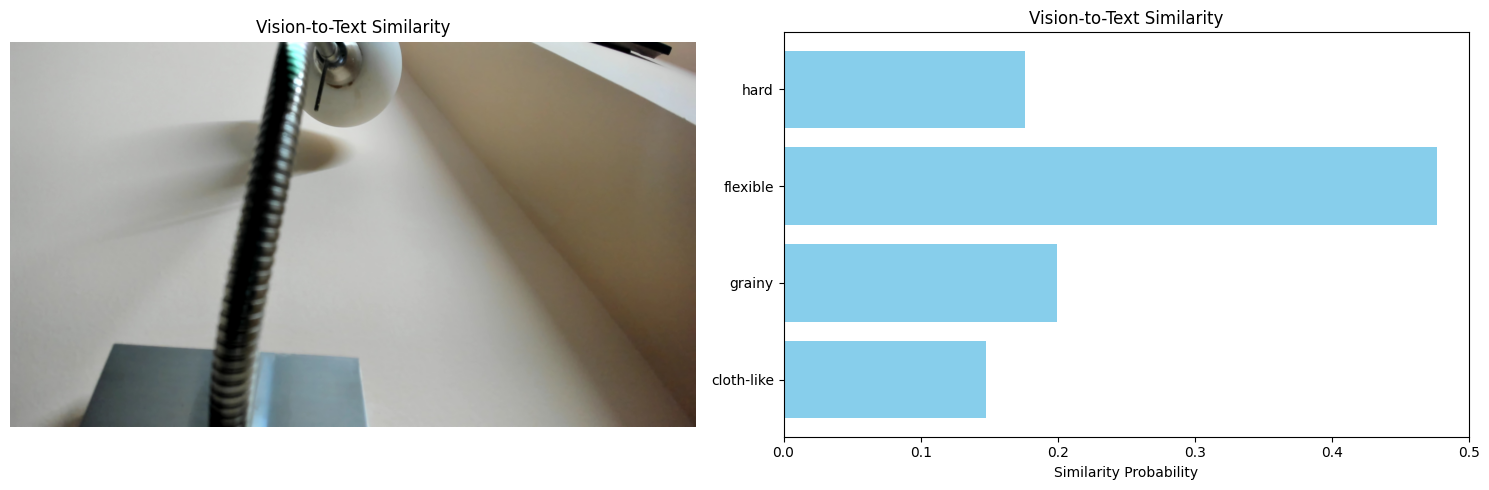

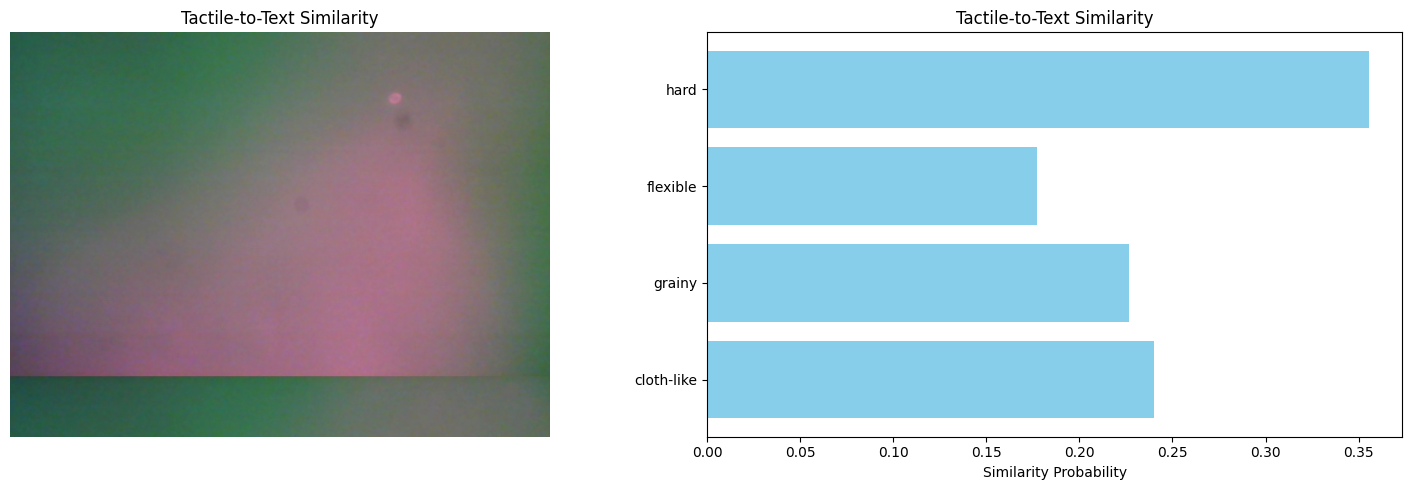

In [21]:
IMAGE_NAME = '2844-0.0296480655670166'
TACTILE_IMAGE_PATH = "tactile/"+IMAGE_NAME+".jpg"
IMAGE_PATH = "image/"+IMAGE_NAME+".jpg"

# Do inference
inference_on_image(TACTILE_IMAGE_PATH, IMAGE_PATH, tactile_opposites, model_tvl)

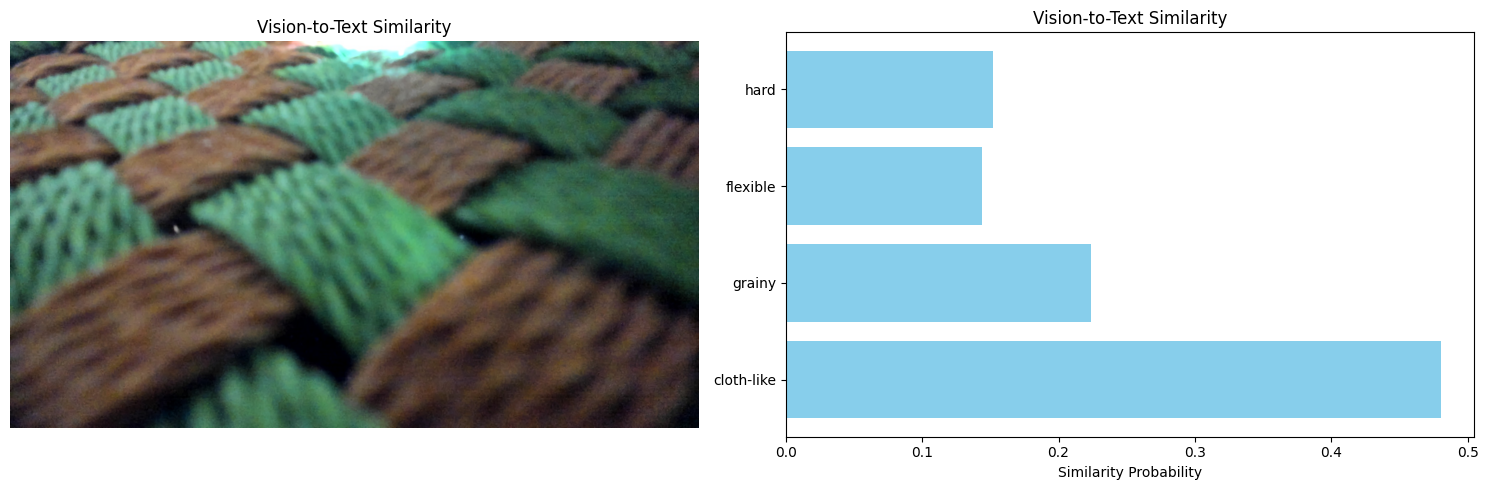

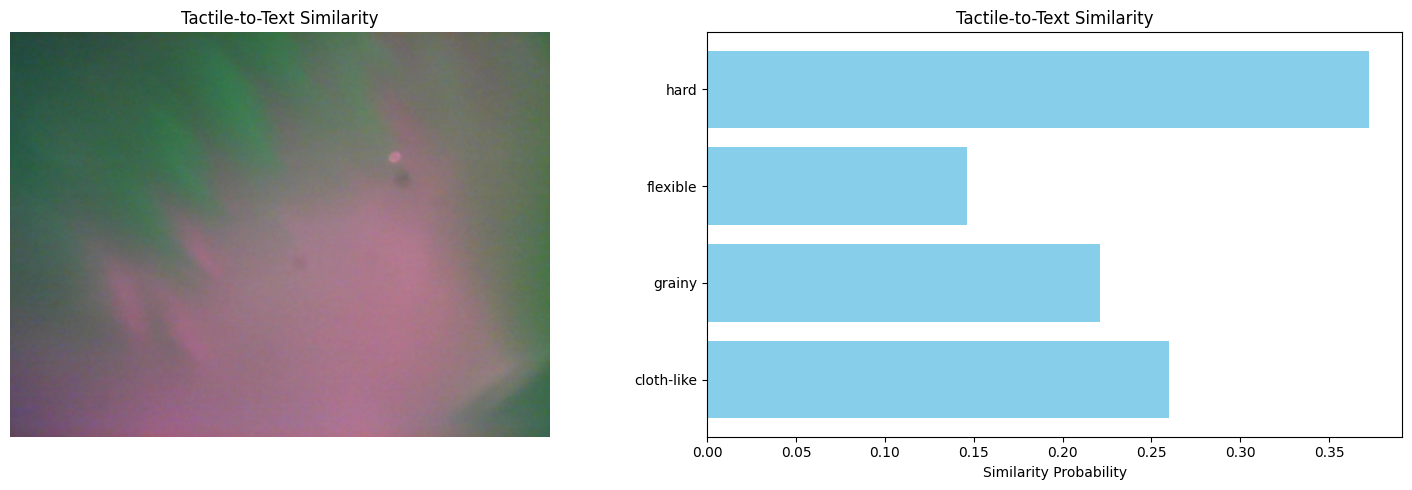

In [20]:
IMAGE_NAME = '132-0.03245687484741211'
TACTILE_IMAGE_PATH = "tactile/"+IMAGE_NAME+".jpg"
IMAGE_PATH = "image/"+IMAGE_NAME+".jpg"

# Do inference
inference_on_image(TACTILE_IMAGE_PATH, IMAGE_PATH, tactile_opposites, model_tvl)